# Figure S6B
#### spatial correlation - ovary cancer sample

In [39]:
import s3fs
import os
import pandas as pd
import tifffile
from matplotlib import pyplot as plt
import numpy as np
import h5py
import helper
from tqdm import tqdm
import scanpy as sc
import json
%load_ext autoreload
%autoreload 2
sc.settings.set_figure_params(dpi=70, facecolor='white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from scipy.stats import pearsonr,spearmanr
import multiprocessing as mp
import seaborn as sns
from scipy import spatial

In [4]:
#settings
plt.rcParams['figure.figsize'] = [5, 5]
#load from helper
dataPath=helper.dataPath
fs=helper.fs

In [6]:
experimentName = 'HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021'

In [7]:
fs.ls(os.path.join(dataPath, experimentName))

['1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0']

In [8]:
fs.ls(os.path.join(dataPath, experimentName,'region_0'))

['1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021_region_0.vzg',
 '1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0/cell_boundaries',
 '1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0/cell_by_gene.csv',
 '1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0/cell_metadata.csv',
 '1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0/detected_transcripts.csv',
 '1701-vizgen-internal/intermediate_analysis/HuOvarCanc_723536FT2_VS15_Cellbound_V6_NP_10-18-2021/region_0/images']

## Load csv files - detected transcripts

In [9]:
detectedTranscripts = pd.read_csv(fs.open(os.path.join(
    dataPath, experimentName,'region_0/', 'detected_transcripts.csv')), index_col=0)

In [10]:
detectedTranscripts.head()

,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id
2299,1,120.448586,3541.7170,0.0,1678.4247,193.59569,0,FCGR2A,ENST00000271450
2704,1,67.957760,3611.7322,0.0,1192.3986,841.88600,0,FCGR2A,ENST00000271450
2754,1,58.372974,3619.9395,0.0,1103.6505,917.87870,0,FCGR2A,ENST00000271450
3250,1,79.943130,3704.8447,0.0,1303.3741,1704.03850,0,FCGR2A,ENST00000271450
4454,1,120.167080,3708.4856,1.0,1675.8181,1737.75020,0,FCGR2A,ENST00000271450


In [11]:
detectedTranscripts.describe()

,barcode_id,global_x,global_y,global_z,x,y,fov
count,3.420433e+07,3.420433e+07,3.420433e+07,3.420433e+07,3.420433e+07,3.420433e+07,3.420433e+07
mean,1.887844e+02,2.578946e+03,5.468160e+03,2.800580e+00,1.000808e+03,1.037227e+03,7.003680e+02
std,9.517242e+01,1.438207e+03,3.058479e+03,1.971954e+00,5.139633e+02,5.155417e+02,4.117334e+02
min,0.000000e+00,-7.008353e+01,-1.340096e+02,0.000000e+00,4.118394e+01,4.233885e-01,0.000000e+00
25%,1.130000e+02,1.348201e+03,2.955873e+03,1.000000e+00,5.660819e+02,6.043360e+02,3.410000e+02
50%,1.980000e+02,2.570390e+03,5.470337e+03,3.000000e+00,9.954506e+02,1.045606e+03,7.000000e+02
75%,2.570000e+02,3.753105e+03,7.845866e+03,4.000000e+00,1.429164e+03,1.473260e+03,1.044000e+03
max,3.840000e+02,5.603088e+03,1.181130e+04,6.000000e+00,2.003593e+03,2.046428e+03,1.492000e+03


## explore with 105um regions

In [12]:
df=detectedTranscripts
df[['x','y']]=df[['x','y']]*0.108 #pixel to micron
df['fov2']=df.fov
df=df.drop(columns=['transcript_id','barcode_id'])

In [13]:
size=105

In [14]:
%%time
lst=[]
count=0
for fov in tqdm(df.fov.unique()):
    _temp=df[df.fov==fov]
    for x in range(0,210,size):
        for y in range(0,210,size):
            _t=_temp[(_temp.x>=x)&(_temp.x<=x+size)&(_temp.y>=y)&(_temp.y<=y+size)].copy()
            _t['fov2']=count
            lst.append(_t)
            count+=1

100%|██████████| 1493/1493 [00:58<00:00, 25.60it/s]

CPU times: user 50.5 s, sys: 8.05 s, total: 58.6 s
Wall time: 58.6 s


In [15]:
%%time
df2=pd.concat(lst)

CPU times: user 470 ms, sys: 525 ms, total: 995 ms
Wall time: 994 ms


In [16]:
df2=df2[['global_x', 'global_y', 'gene', 'fov','fov2']]

In [17]:
df2.to_parquet('HuOvarCanc_723536FT2_VS15_'+str(size)+'um_fov.parquet')  


In [19]:
df2=pd.read_parquet('HuOvarCanc_723536FT2_VS15_'+str(size)+'um_fov.parquet')  
df2

,global_x,global_y,gene,fov,fov2
1686377,44.026030,3585.8313,JUN,0,0
1704334,-42.677280,3604.1216,WARS,0,0
1706931,42.024630,3541.6572,VEGFA,0,0
1850672,44.083520,3587.9265,SELE,0,0
2214423,24.999739,3570.3472,INSR,0,0
...,...,...,...,...,...
2766399,5560.472700,4206.8413,Blank-37,1492,5971
2766468,5526.192400,4212.4785,Blank-37,1492,5971
2772937,5542.418000,4288.0570,Blank-37,1492,5971
2781762,5521.141000,4277.3413,Blank-38,1492,5971


In [10]:
detectedTranscripts = detectedTranscripts[['global_x', 'global_y', 'gene', 'fov']]

In [11]:
detectedTranscripts.head()

,global_x,global_y,gene,fov
2299,120.448586,3541.7170,FCGR2A,0
2704,67.957760,3611.7322,FCGR2A,0
2754,58.372974,3619.9395,FCGR2A,0
3250,79.943130,3704.8447,FCGR2A,0
4454,120.167080,3708.4856,FCGR2A,0


In [ ]:
detectedTranscripts['x'].max()

In [ ]:
detectedTranscripts.fov()

## FOV correlation

## generate a matrix with count of each gene in each FOV

In [41]:
%%time
_t=pd.DataFrame(df2.groupby(['fov2','gene']).size()).unstack(fill_value=0)

CPU times: user 2.02 s, sys: 581 ms, total: 2.6 s
Wall time: 2.6 s


In [42]:
_t.columns = _t.columns.droplevel()

In [31]:
%%time
hm=pd.DataFrame()

genes=["PTPRC","CD8A","CD3E","CD3D","C1QC","CD163","CD79A","MS4A1","TRAC",
       "ACTA2","VWF","PECAM1","COL1A1","CD4",'CLDN4',"CD14",'MUC1','EPCAM',"TREM2",
       "TIGIT","CDH1",'PDGFRA','RGS5']

for i in tqdm(genes):
    lst=[]
    for j in genes:
        corr,_=pearsonr(_t[i].values, _t[j].values)
        lst.append(pd.DataFrame([{'Gene_A':i,'Gene_B':j,'corr':corr}]))
    results_df = pd.concat(lst)
    hm=pd.concat([hm,pd.DataFrame.from_dict(results_df)],ignore_index=True)

100%|██████████| 23/23 [00:00<00:00, 42.03it/s]

CPU times: user 550 ms, sys: 66 µs, total: 550 ms
Wall time: 549 ms


In [32]:
hm.sort_values(by='corr').head(3)

,Gene_A,Gene_B,corr
290,COL1A1,CLDN4,-0.344412
334,CLDN4,COL1A1,-0.344412
292,COL1A1,MUC1,-0.276182


In [36]:
import seaborn as sns; sns.set_theme()

[]

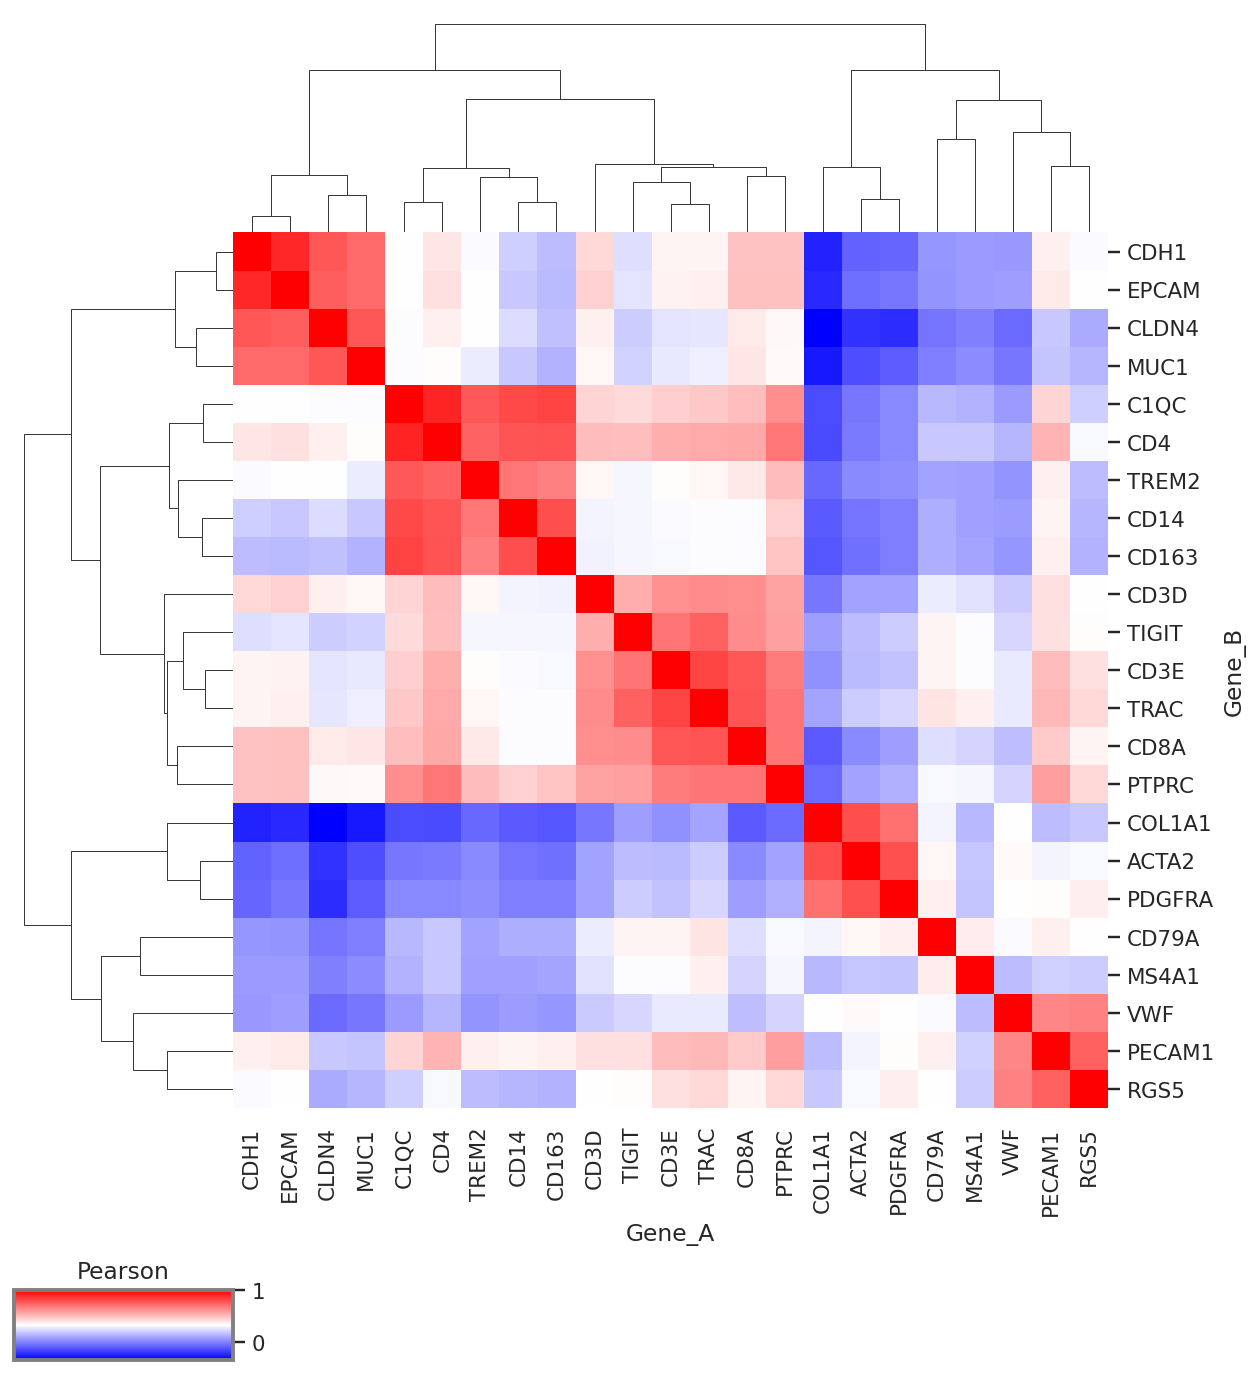

In [38]:
total_norm=hm.pivot(index='Gene_A', columns='Gene_B', values='corr').fillna(0).T
g =sns.clustermap(total_norm, cmap="bwr", row_cluster=True ,col_cluster=True,vmin=hm['corr'].min(), vmax=1,
                      figsize=(10,10))
g.fig.subplots_adjust(left=0.1,bottom=0.2)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.1, 0.02, g.ax_row_dendrogram.get_position().width, 0.05])
g.ax_cbar.set_title('Pearson')
g.ax_cbar.tick_params(axis='x', length=10)
for spine in g.ax_cbar.spines:
    g.ax_cbar.spines[spine].set_color('gray')
    g.ax_cbar.spines[spine].set_linewidth(2)
plt.savefig('./figs/heatmap.pdf')
plt.plot()